In [1]:
#!pip install tensorflow[and-cuda]
#!pip install keras-tuner

In [2]:
#!pip install pandas
#!pip install networkx
#!pip install matplotlib
#!pip install scikit-learn

In [1]:
import pandas as pd
from keras.src.layers import Bidirectional

from component_module import drop_static_columns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# for keras tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import random
import matplotlib.pyplot as plt
import numpy as np
from time import time
import os
import shutil

2024-10-05 13:43:42.749155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 13:43:42.763946: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 13:43:42.768552: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 13:43:42.779848: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-05 13:43:43.409026: W tensorflow/compiler/tf2

In [2]:
# Check if TensorFlow is built with CUDA support
if tf.config.list_physical_devices('GPU'):
    print("CUDA is available")
    print(f"Device: {tf.config.list_physical_devices('GPU')[0]}")
else:
    print("CUDA is not available")

CUDA is available
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1728132224.033890 1190135 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728132224.073309 1190135 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728132224.073571 1190135 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
df = pd.read_csv("/home/loz/MSc/MSc_Project/SWaT_12_23_sec_minmax.csv", index_col='time_in_seconds')

In [4]:
df.head()

,FIT101,LIT101,MV101,P101,AIT201,AIT202,AIT203,FIT201,MV201,P203,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,P602
time_in_seconds,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.990606,0.5,1.0,1.000000,0.128753,0.498588,0.769136,1.0,0.0,...,0.686274,0.56685,0.541283,0.429823,0.344541,0.390927,0.238806,0.402412,0.0,0.0
1,0.0,0.989536,0.5,1.0,1.000000,0.128753,0.499496,0.863706,1.0,1.0,...,0.686274,0.56685,0.421003,0.429823,0.546218,0.382286,0.238806,0.402412,0.0,0.0
2,0.0,0.989536,0.5,1.0,1.000000,0.128753,0.501614,0.916761,1.0,1.0,...,0.686274,0.56685,0.408771,0.429823,0.546218,0.360690,0.238806,0.400006,0.0,0.0
3,0.0,0.989417,0.5,1.0,0.966105,0.125893,0.504035,0.952045,1.0,1.0,...,0.686274,0.56685,0.460754,0.622810,0.546218,0.360690,0.238806,0.378318,0.0,0.0
4,0.0,0.988585,0.5,1.0,0.966105,0.125893,0.507466,0.974452,1.0,1.0,...,0.686274,0.56685,0.580023,0.622810,0.546218,0.388771,0.238806,0.378318,0.0,0.0


In [5]:
# check data is in time order
#df.sort_values(by='time_in_seconds', inplace=True)

In [6]:
df_just_lit = df.copy()
df_just_lit.shape

(86400, 37)

In [7]:
# v2 including MV components
#lit_columns = ['FIT101', 'FIT301', 'FIT401', 'FIT501', 'FIT502','FIT503', 'FIT504',
#                   'MV101', 'MV201', 'MV301', 'MV302', 'MV303', 'MV304',
#                   'P101', 'P203', 'P205', 'P301', 'P302', 'P602']

#lit_columns.sort()
#lit_columns.extend(["LIT101", "LIT301", "LIT401"])

In [8]:
#component_map = list(df.columns)
#len(component_map)

In [9]:
#lit_columns

In [10]:
#lit_101_columns
#df_just_lit = df_just_lit[lit_columns]
#df_just_lit

In [11]:
# force MV values to 0 and 1
#mv_columns = ['MV101', 'MV201', 'MV301', 'MV302', 'MV303', 'MV304']
##df_just_lit[mv_columns] = df_just_lit[mv_columns].replace({0.5: 0, 1: 1})

In [12]:
#df_just_lit101.columns
#df_just_lit.to_csv("/home/loz/MSc/MSc_Project/SWaT_sec_minmax_14_lit_comps.csv")
df_just_lit = pd.read_csv("/home/loz/MSc/MSc_Project/SWaT_sec_minmax_14_lit_comps.csv", index_col='time_in_seconds')

In [13]:
df_just_lit.columns

Index(['FIT101', 'FIT301', 'FIT401', 'FIT501', 'FIT502', 'FIT503', 'FIT504',
       'MV101', 'MV201', 'MV301', 'MV302', 'MV303', 'MV304', 'P101', 'P203',
       'P205', 'P301', 'P302', 'P602', 'LIT101', 'LIT301', 'LIT401'],
      dtype='object')

In [14]:
#df_just_lit.MV302.iloc[2000:8200].plot()

In [15]:
df_just_lit

,FIT101,FIT301,FIT401,FIT501,FIT502,FIT503,FIT504,MV101,MV201,MV301,...,MV304,P101,P203,P205,P301,P302,P602,LIT101,LIT301,LIT401
time_in_seconds,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.937096,0.552146,0.566850,0.541283,0.429823,0.344541,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.990606,0.029293,0.181115
1,0.0,0.936390,0.524523,0.566850,0.421003,0.429823,0.546218,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.989536,0.028592,0.182798
2,0.0,0.936009,0.524523,0.566850,0.408771,0.429823,0.546218,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.989536,0.028592,0.182124
3,0.0,0.935955,0.524523,0.566850,0.460754,0.622810,0.546218,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.989417,0.025785,0.182966
4,0.0,0.935955,0.524523,0.566850,0.580023,0.622810,0.546218,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.988585,0.022277,0.184649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,0.0,0.941496,0.616559,0.633712,0.428134,0.429823,0.319327,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.984067,0.779862,0.037199
86396,0.0,0.941496,0.561338,0.633712,0.405708,0.429823,0.319327,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.983948,0.778985,0.039387
86397,0.0,0.941496,0.546018,0.598830,0.509681,0.429823,0.319327,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.983591,0.777055,0.038714


In [16]:
#df_test.set_index('time_in_seconds', inplace=True)
#data_array = df_test.to_numpy()
data_array = df_just_lit.to_numpy()



In [17]:
type(data_array)

numpy.ndarray

In [18]:
# Window size in seconds
#window_size = 20
# Define batch of windows to process in parallel before updating weights 
#batch_size = 32
# use full dataset size to suffle within



def windowed_dataset(data_array, window_size, batch_size, shuffle_buffer_size):
    '''
    get full dataset as np array
    :param data_array: 
    :param window_size: 
    :param batch_size: 
    :param shuffle_buffer_size:  window of data rows to shuffle within
    :return: 
    '''
    
    # Create a TensorFlow dataset from the NumPy array
    dataset = tf.data.Dataset.from_tensor_slices(data_array)

    # Window the dataset into n second long slices with a 1 sec shift between each
    dataset = dataset.window(size=window_size, shift=1, drop_remainder=True)
    
    # Flatten the windowed dataset for input layer
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Split window into features and labels (last column of last row) keeping full row as labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1,:]))
    
    # Shuffle the windows to avoid sequencial windows with similar characteristics
    dataset = dataset.shuffle(shuffle_buffer_size)
    

    
    # batch and cache to keep whole dataset in memory. Prefetch to have next batch ready in memory
    dataset = dataset.batch(batch_size)
    #dataset = dataset.cache()
    # set indefinite repeat to allow looping back through
    #dataset = dataset.repeat()
    #dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    # split
    split_time = int(len(data_array) * 0.8)
    
    train_dataset = dataset.take(split_time // batch_size)  # Take the first 80% of batches
    val_dataset = dataset.skip(split_time // batch_size)  # Skip the first 80% of batches
    
    return train_dataset, val_dataset
    
    

In [19]:
train_dataset, val_dataset = windowed_dataset(data_array, 20, 32, 80000)
train_dataset.take(1)
# Check the first window
for features, label in train_dataset.take(1):
    print("Features shape: ", features.shape)  # Should be (32, 19, 22)
    print("Label shape: ", label.shape)        # Should be (32,22)
    

I0000 00:00:1728132240.891984 1190135 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728132240.892416 1190135 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728132240.892726 1190135 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728132240.990112 1190135 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Features shape:  (32, 19, 22)
Label shape:  (32, 22)


2024-10-05 13:44:05.532754: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
#sample = train_dataset.take(1)

In [25]:
#for features, label in sample:
 #   print("Features shape: ", label) 

In [47]:


def build_model_tuner(hp, window_size, data_array_shape):
    '''
    Function to build model based on hyper parameters passed by random search
    
    params:
    hp: Hyper parameters passed by random search
     
    returns: 
    model: Keras model
    
    '''
    # Define the model
    model = Sequential()
    

    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array_shape)))
    
    # Range of LSTM units for tuner
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=96, step=16)
    # Add an LSTM layer with tuner range 
    model.add(LSTM(units=lstm_units))
    
    # Tune the number of units in the dense layer
    dense_units = hp.Int('dense_units', min_value=32, max_value=96, step=16)
    model.add(Dense(dense_units, activation='relu'))
    
    # Dense output layer predicting a single component at the next timestep
    model.add(Dense(3))
    
    # Tune the learning rate for the optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-4, sampling='LOG')
    
    
    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    return model #, epochs, steps_per_epoch



In [48]:


# Directory for model performance logs
LOG_DIR = os.path.join("my_tuner_logs")
BI_LOG_DIR = os.path.join("my_bi_tuner_logs")



shuffle_buffer_size = data_array.shape[0]
# avoid over fitting
early_stop = EarlyStopping(monitor='val_loss', patience=3)




#window_sizes = [n for n in range(20,100,20)]
#batch_sizes = [16,32,64]

window_sizes = [20]
batch_sizes = [32]

# Results Dictionary
results = {}

for window_size in window_sizes:
    for batch_size in batch_sizes:
        print(f'Window Size:{window_size}, Batch Size:{batch_size}')
        train_dataset, val_dataset = windowed_dataset(data_array, window_size, batch_size, shuffle_buffer_size)
        
        # Clear logs to run tuner from scratch
        if os.path.exists(LOG_DIR):
            shutil.rmtree(LOG_DIR) 
            
        num_features = data_array.shape[1]
        
        # keras tuner to find optimum model
        tuner = RandomSearch(
            lambda hp: build_model_tuner(hp, window_size, num_features),
            objective = "val_loss",
            max_trials = 5,
            executions_per_trial = 1,
            directory = LOG_DIR,
            project_name = "lstm_all_data"
        )
        
        early_stop = EarlyStopping(monitor='val_loss', patience=3)
        
        # Train the tuner
        tuner.search(  
            train_dataset,  # Pass your windowed and batched training dataset
            epochs=4,
            validation_data=val_dataset,  # Pass your windowed and batched validation dataset
            callbacks=[early_stop]
        )       
        
        # Retrieve the best model's hyperparameters and scores
        best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
        best_hps = best_trial.hyperparameters.values
        best_score = best_trial.score
        
        # Store the results in the dictionary
        results[f"window_{window_size}_batch_{batch_size}"] = {
            "window_size": window_size,
            "batch_size": batch_size,
            "lstm_units": best_hps['lstm_units'],
            "dense_units": best_hps['dense_units'],
            "learning_rate": best_hps['learning_rate'],
            "MSE": best_score,  # Assuming val_loss is MSE
            "MAE": best_trial.metrics.metrics['mae'].get_statistics()['min']
        }
        
        print(results[f"window_{window_size}_batch_{batch_size}"] )

        
    

Trial 5 Complete [00h 01m 19s]
val_loss: 0.001306021586060524

Best val_loss So Far: 5.700465044355951e-05
Total elapsed time: 00h 06m 40s
{'window_size': 20, 'batch_size': 32, 'lstm_units': 64, 'dense_units': 64, 'learning_rate': 4.089247459348165e-05, 'MSE': 5.700465044355951e-05, 'MAE': 0.005889344960451126}


In [49]:
results

{'window_20_batch_32': {'window_size': 20,
  'batch_size': 32,
  'lstm_units': 64,
  'dense_units': 64,
  'learning_rate': 4.089247459348165e-05,
  'MSE': 5.700465044355951e-05,
  'MAE': 0.005889344960451126}}

In [50]:
# Best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/home/loz/MSc/MSc_Project/venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,627 (104.01 KB)

 Trainable params: 26,627 (104.01 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [52]:
best_hps.values

{'lstm_units': 64, 'dense_units': 64, 'learning_rate': 4.089247459348165e-05}

In [58]:


def build_best_model(tuner):
    '''
    Function to build model based on hyper parameters 
    
    params:
    params_dict: params returned from tuner including lstm, dense layer and learning rate
     
    returns: 
    model: Keras model
    
    '''
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    lstm_units = best_hps.values['lstm_units']
    dense_units = best_hps.values['dense_units']
    learning_rate = best_hps.values['learning_rate']
    window_size = 20
    #lstm_units = 80
    #dense_units = 48
    #learning_rate = 1.8345582484066496e-05

    # Define the model
    model = Sequential()
    
    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Add an LSTM layer with best number of units (neurons)
    model.add(LSTM(lstm_units))
    
    # add dense layer
    model.add(Dense(dense_units, activation='relu'))
    
    # Dense output layer predicting the next timestep
    model.add(Dense(3)) 
    
    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    return model



train_dataset, val_dataset = windowed_dataset(data_array, 20, 32, 80000)
train_dataset.take(1)
# Check the first window
for features, label in train_dataset.take(1):
    print("Features shape: ", features.shape)  # Should be (3219, 14)
    print("Label shape: ", label.shape)        # Should be (32,1)

In [59]:
swat_lstm_lit = build_best_model(tuner)

In [60]:

# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
history = swat_lstm_lit.fit(
    train_dataset,
    epochs=6,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset
)

Epoch 1/6
   2154/Unknown 14s 4ms/step - loss: 0.0637 - mae: 0.1523

2024-10-04 22:32:47.997154: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18191193701997457167
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-04 22:32:47.997214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13794323456945773306
2024-10-04 22:32:47.997263: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13312804592070235542


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0636 - mae: 0.1520 - val_loss: 6.5269e-04 - val_mae: 0.0181
Epoch 2/6


2024-10-04 22:32:53.734699: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7807224421914420155
2024-10-04 22:32:53.734754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16691367961860853587


2158/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7481e-04 - mae: 0.0152

2024-10-04 22:33:07.740468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18191193701997457167
2024-10-04 22:33:07.740527: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13794323456945773306
2024-10-04 22:33:07.740560: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13312804592070235542


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 4.7464e-04 - mae: 0.0152 - val_loss: 1.9980e-04 - val_mae: 0.0101
Epoch 3/6


2024-10-04 22:33:13.082432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7807224421914420155
2024-10-04 22:33:13.082493: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14638103776977675483
2024-10-04 22:33:13.082506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16691367961860853587


2156/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5822e-04 - mae: 0.0090

2024-10-04 22:33:27.371434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18191193701997457167
2024-10-04 22:33:27.371489: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13794323456945773306
2024-10-04 22:33:27.371529: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13312804592070235542


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1.5816e-04 - mae: 0.0090 - val_loss: 8.9929e-05 - val_mae: 0.0069
Epoch 4/6


2024-10-04 22:33:32.816602: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7807224421914420155
2024-10-04 22:33:32.816639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14638103776977675483
2024-10-04 22:33:32.816652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16691367961860853587


2150/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1817e-05 - mae: 0.0065

2024-10-04 22:33:47.020194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18191193701997457167
2024-10-04 22:33:47.020232: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13794323456945773306
2024-10-04 22:33:47.020248: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13312804592070235542


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 8.1771e-05 - mae: 0.0065 - val_loss: 5.3391e-05 - val_mae: 0.0053
Epoch 5/6


2024-10-04 22:33:52.510226: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7807224421914420155
2024-10-04 22:33:52.510280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16691367961860853587


2150/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2277e-05 - mae: 0.0053

2024-10-04 22:34:06.959208: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18191193701997457167
2024-10-04 22:34:06.959275: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13794323456945773306
2024-10-04 22:34:06.959313: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13312804592070235542


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 5.2256e-05 - mae: 0.0053 - val_loss: 4.3382e-05 - val_mae: 0.0049
Epoch 6/6


2024-10-04 22:34:12.403692: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 22:34:12.403739: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7807224421914420155
2024-10-04 22:34:12.403776: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16691367961860853587


2158/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8501e-05 - mae: 0.0046

2024-10-04 22:34:26.594966: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18191193701997457167
2024-10-04 22:34:26.595022: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13794323456945773306
2024-10-04 22:34:26.595063: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13312804592070235542


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 3.8498e-05 - mae: 0.0046 - val_loss: 3.0914e-05 - val_mae: 0.0041


2024-10-04 22:34:32.096753: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7807224421914420155
2024-10-04 22:34:32.096796: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14638103776977675483
2024-10-04 22:34:32.096808: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16691367961860853587


In [61]:
#swat_lstm_lit.save('swat_lstm_lit.keras')

In [62]:
swat_lstm_lit

<Sequential name=sequential_2, built=True>

## Tuner Version

# Open Saved Model

In [37]:
# Load the model from the SavedModel directory
# 20 secs
#swat_lstm = tf.keras.models.load_model('swat_lstm_1_0.keras')
#swat_lstm = tf.keras.models.load_model('best_model.keras')
#model_window = 20
# only for predict so no optimiser so compile  = false
swat_lstm_lit = tf.keras.models.load_model('swat_lstm_lit.keras', compile=False)
#model_window = 20

In [63]:
# Reshape the input from data_array to add the batch dimension
model_window = 20
reshaped_input = data_array[:model_window-1, :].reshape(1, model_window-1, data_array.shape[1])  # (1, 19, 37)


In [64]:
reshaped_input.shape

(1, 19, 22)

In [65]:
reshaped_input

array([[[0.        , 0.93709565, 0.55214592, 0.56685038, 0.54128302,
         0.4298233 , 0.34454123, 0.        , 1.        , 0.        ,
         1.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 1.        , 0.        , 0.99060632,
         0.02929309, 0.18111452],
        [0.        , 0.93638966, 0.52452306, 0.56685038, 0.42100321,
         0.4298233 , 0.54621783, 0.        , 1.        , 0.        ,
         1.        , 0.        , 0.        , 1.        , 1.        ,
         0.        , 0.        , 1.        , 0.        , 0.9895364 ,
         0.02859152, 0.18279767],
        [0.        , 0.93600931, 0.52452306, 0.56685038, 0.4087715 ,
         0.4298233 , 0.54621783, 0.        , 1.        , 0.        ,
         1.        , 0.        , 0.        , 1.        , 1.        ,
         0.        , 0.        , 1.        , 0.        , 0.9895364 ,
         0.02859152, 0.18212441],
        [0.        , 0.93595504, 0.52452306, 0.56685038, 0.46075428,
 

In [67]:

# Make predictions
predictions = swat_lstm_lit.predict(reshaped_input)

# Print predictions
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
[[0.96326447 0.01836903 0.19044904]]


In [74]:
actual = data_array[model_window-1:model_window, -3:]

In [75]:
actual

array([[0.96908448, 0.01052475, 0.18902553]])

In [119]:
reshaped_input.shape

(1, 19, 22)

In [76]:
actual

array([[0.96908448, 0.01052475, 0.18902553]])

In [77]:
difference = actual - predictions

# Print results
print("Predictions:\n", predictions)
print("Actual Values:\n", actual)
print("Difference:\n", difference)

Predictions:
 [[0.96326447 0.01836903 0.19044904]]
Actual Values:
 [[0.96908448 0.01052475 0.18902553]]
Difference:
 [[ 0.00582001 -0.00784428 -0.00142351]]


In [83]:
type(difference)

numpy.ndarray

# Predict Whole Dataset

In [78]:
split_time = int(data_array.shape[0] * 0.8)

val_dataset = data_array[split_time:]
##predict first 100 
predict_dataset = val_dataset[:1200]

In [71]:
#predict_dataset

In [72]:
#len(val_dataset)

In [73]:
#input_window.shape

In [87]:
# Define a list to hold all predictions
all_predictions_lit101 = []
all_predictions_lit301 = []
all_predictions_lit401 = []

# Loop through the dataset and predict step by step
for i in range(len(predict_dataset) - model_window + 1):
    # Extract the window of input data for prediction
    input_window = predict_dataset[i:i+model_window-1, :].reshape(1, model_window-1, data_array.shape[1])
    
    # Predict the next timestep
    predictions = swat_lstm_lit.predict(input_window)
    lit101, lit301, lit401 = predictions[0]
    
    # Save prediction
    all_predictions_lit101.append(lit101)  
    all_predictions_lit301.append(lit301)
    all_predictions_lit401.append(lit401)

# Convert predictions list to numpy array
all_predictions_lit101 = np.array(all_predictions_lit101)
all_predictions_lit301 = np.array(all_predictions_lit301)
all_predictions_lit401 = np.array(all_predictions_lit401)

index = np.arange(model_window - 1, len(predict_dataset))


df_predictions = pd.DataFrame({
    "LIT101": all_predictions_lit101,
    "LIT301": all_predictions_lit301,
    "LIT401": all_predictions_lit401
}, index=index)


# Convert predictions list to numpy array
#all_predictions = np.array(all_predictions)


# Get the actual data for comparison (the next step in each window)
actual_data_lit101 = predict_dataset[model_window - 1:, -3]  # Adjust index based on LIT101's position
actual_data_lit301 = predict_dataset[model_window - 1:, -2]  # Adjust index based on LIT301's position
actual_data_lit401 = predict_dataset[model_window - 1:, -1]  # Adjust index based on LIT401's position

mae_lit101 = np.mean(np.abs(all_predictions_lit101 - actual_data_lit101))
mae_lit301 = np.mean(np.abs(all_predictions_lit301 - actual_data_lit301))
mae_lit401 = np.mean(np.abs(all_predictions_lit401 - actual_data_lit401))

#df_predictions = pd.DataFrame({"LIT101": all_predictions}, index=index)


#  error metrics
mae_lit101 = np.mean(np.abs(all_predictions_lit101 - actual_data_lit101))
mae_lit301 = np.mean(np.abs(all_predictions_lit301 - actual_data_lit301))
mae_lit401 = np.mean(np.abs(all_predictions_lit401 - actual_data_lit401))

print(f"Mean Absolute Error for LIT101: {mae_lit101}")
print(f"Mean Absolute Error for LIT301: {mae_lit301}")
print(f"Mean Absolute Error for LIT401: {mae_lit401}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

In [88]:
actual_data

NameError: name 'actual_data' is not defined

In [89]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1181 entries, 19 to 1199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LIT101  1181 non-null   float32
 1   LIT301  1181 non-null   float32
 2   LIT401  1181 non-null   float32
dtypes: float32(3)
memory usage: 23.1 KB


In [90]:
predict_dataset.shape

(1200, 22)

In [132]:
actual_values = predict_dataset[-1,:]

In [133]:
actual_values

array([0.        , 0.09279063, 1.        , 0.        , 0.54433895,
       0.        , 0.        , 1.        , 0.93964866, 0.        ,
       0.        , 1.        , 0.        , 0.33333333, 0.30028659,
       0.64244404, 0.30252145, 1.        , 1.        , 1.        ,
       0.70244393, 0.50523195])

In [134]:
all_predictions.shape

(1181,)

In [135]:
predict_dataset = predict_dataset[window_size-1:]

In [136]:
# Shift predictions by 1 step forward to account for the lag
shifted_predictions = np.insert(all_predictions, 0, np.nan)  # Insert NaN at the beginning to shift predictions
shifted_predictions = shifted_predictions[:-1]  # Remove the last value to maintain the array length

# Compare shifted predictions to the original actual data
mae = np.mean(np.abs(shifted_predictions[~np.isnan(shifted_predictions)] - actual_data))
print(f"Mean Absolute Error: {mae}")


ValueError: operands could not be broadcast together with shapes (1180,) (1181,) 

In [137]:
df_actual = pd.DataFrame(predict_dataset, columns=lit_101_columns)
df_actual.info

<bound method DataFrame.info of       P602    LIT301  MV201    FIT101    FIT502  MV101  MV304  P101    FIT301  \
0      0.0  0.980880    0.0  0.948097  0.626913    1.0    0.0   0.0  0.000109   
1      0.0  0.981581    0.0  0.943682  0.542302    1.0    0.0   0.0  0.000109   
2      0.0  0.980354    0.0  0.936523  0.537208    1.0    0.0   0.0  0.000109   
3      0.0  0.980000    0.0  0.930915  0.537208    1.0    0.0   0.0  0.000109   
4      0.0  0.980000    0.0  0.924472  0.537208    1.0    0.0   0.0  0.000109   
...    ...       ...    ...       ...       ...    ...    ...   ...       ...   
1176   0.0  0.090686    1.0  0.000000  0.503569    0.0    0.0   1.0  0.938562   
1177   0.0  0.092966    1.0  0.000000  0.449541    0.0    0.0   1.0  0.938562   
1178   0.0  0.092966    1.0  0.000000  0.449541    0.0    0.0   1.0  0.938562   
1179   0.0  0.092966    1.0  0.000000  0.480124    0.0    0.0   1.0  0.938834   
1180   0.0  0.092791    1.0  0.000000  0.544339    0.0    0.0   1.0  0.939649

In [138]:
actual = df_actual['LIT101'].to_list()

In [139]:
actual

[0.4845422377669406,
 0.4865636502595907,
 0.4878716765061459,
 0.4881094719215113,
 0.4908442706602562,
 0.4920332477370814,
 0.4926278877375416,
 0.4939359139840973,
 0.4952439402306525,
 0.495600784815748,
 0.4963138681377468,
 0.4973840989689373,
 0.4986921252154925,
 0.5014269239542379,
 0.503448336446888,
 0.5049941581088087,
 0.5059453397702685,
 0.5061831351856336,
 0.5070155706014587,
 0.5074911614321889,
 0.5091557293397435,
 0.5087991876787441,
 0.5101072139252996,
 0.5115339864174895,
 0.5124851680789493,
 0.5140309897408697,
 0.5154577622330596,
 0.5164092468186152,
 0.5190249963876301,
 0.52045176887982,
 0.5222356888812012,
 0.5236624613733911,
 0.5258026201116759,
 0.5261594646967713,
 0.5307966267584365,
 0.5317481113439924,
 0.5342451146673726,
 0.5354340917441978,
 0.5365043225753883,
 0.5378120458978473,
 0.5394769167294979,
 0.5416170754677829,
 0.5422117154682435,
 0.5431628971297033,
 0.5457789496228143,
 0.5481569037764638,
 0.5499405208537491,
 0.55112949793057

In [140]:
predictions = df_predictions['LIT101'].to_list()

In [141]:
df_predictions['LIT101'].shape

(1181,)

In [142]:
len(predictions_trim)

1180

In [143]:
len(actual_trim)

1180

In [93]:
predictions_trim = predictions[1:]
actual_trim = actual[:-3]

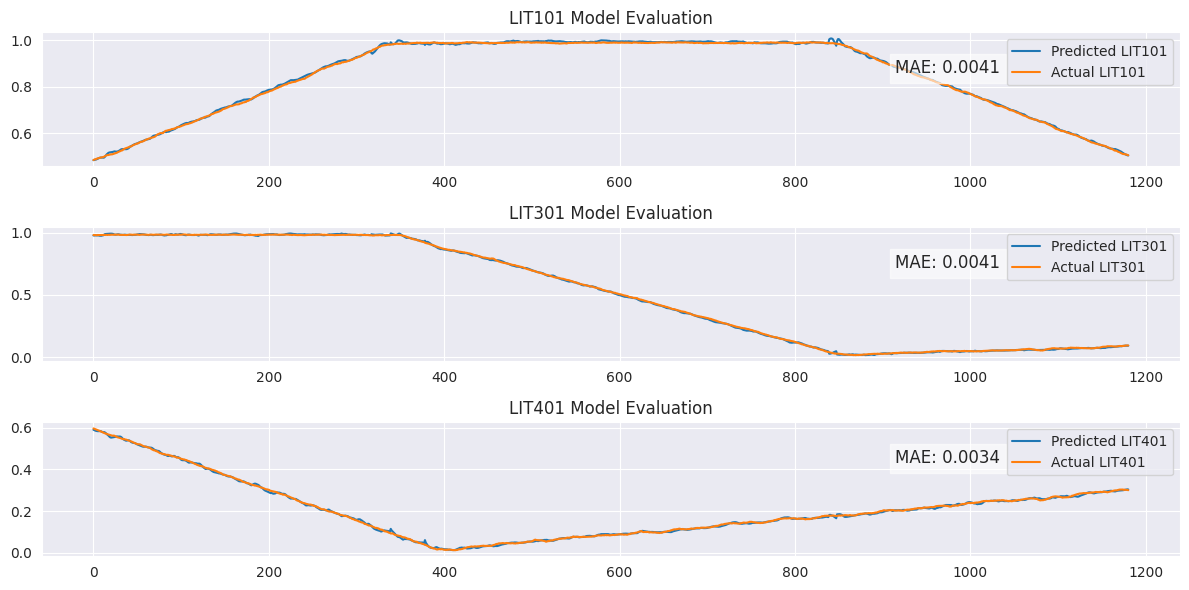

Mean Absolute Error for LIT101: 0.004090389219511621
Mean Absolute Error for LIT301: 0.004071935822920618
Mean Absolute Error for LIT401: 0.003443430899248229


In [96]:

# Assuming predictions_trim and actual_trim are lists or arrays of trimmed predictions and actual values
# for LIT101, LIT301, and LIT401, respectively.
# Example structure for predictions_trim and actual_trim:
# predictions_trim = [all_predictions_lit101, all_predictions_lit301, all_predictions_lit401]
# actual_trim = [actual_data_lit101, actual_data_lit301, actual_data_lit401]

# Plot predictions vs. actual for each variable on the same plot
plt.figure(figsize=(12, 6))

# LIT101
plt.subplot(3, 1, 1)  # Create a 3x1 grid of plots, this is the first plot
plt.plot(all_predictions_lit101, label='Predicted LIT101')
plt.plot(actual_data_lit101, label='Actual LIT101')
plt.title('LIT101 Model Evaluation')
plt.legend()
plt.text(0.75, 0.8, f'MAE: {mae_lit101:.4f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

# LIT301
plt.subplot(3, 1, 2)  # This is the second plot in the 3x1 grid
plt.plot(all_predictions_lit301, label='Predicted LIT301')
plt.plot(actual_data_lit301, label='Actual LIT301')
plt.title('LIT301 Model Evaluation')
plt.legend()
plt.text(0.75, 0.8, f'MAE: {mae_lit301:.4f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

# LIT401
plt.subplot(3, 1, 3)  # This is the third plot in the 3x1 grid
plt.plot(all_predictions_lit401,  label='Predicted LIT401')
plt.plot(actual_data_lit401, label='Actual LIT401')
plt.title('LIT401 Model Evaluation')
plt.legend()
plt.text(0.75, 0.8, f'MAE: {mae_lit401:.4f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('/home/loz/MSc/MSc_Project/Write_Up/Charts/lit101_301_401_dnn.jpeg')
plt.show()

# Print MAE for each variable
print(f"Mean Absolute Error for LIT101: {mae_lit101}")
print(f"Mean Absolute Error for LIT301: {mae_lit301}")
print(f"Mean Absolute Error for LIT401: {mae_lit401}")


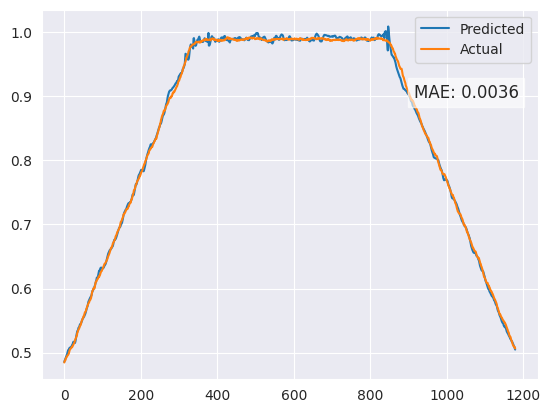

In [145]:
#plt.plot(df_actual['LIT101'], label='Actual')
#plt.plot(df_predictions['LIT101'], label='Predicted')

plt.plot(predictions_trim, label='Predicted')
plt.plot(actual_trim, label='Actual')

#plt.title('LIT101 Model Evaluation')
mae = np.mean(np.abs(np.array(predictions_trim) - np.array(actual_trim)))
plt.legend()
# Add text annotation for MAE on the plot
plt.text(0.75, 0.8, f'MAE: {mae:.4f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))
plt.savefig('/home/loz/MSc/MSc_Project/Write_Up/Charts/lit101_only_dnn.jpeg')
plt.show()
#mae = np.mean(np.abs(df_predictions['LIT101'] - df_actual['LIT101']))
#mae = np.mean(np.abs(np.array(predictions_trim) - np.array(actual_trim)))
#print(f"Mean Absolute Error: {mae}")

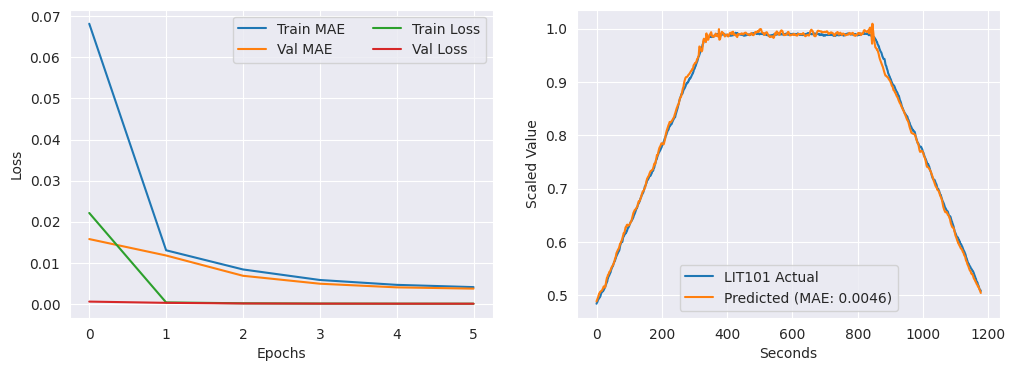

In [149]:
history_1_dict = history.history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)

if 'mae' in history_1_dict:
    plt.plot(history_1_dict['mae'], label='Train MAE')
if 'val_mae' in history_1_dict:
    plt.plot(history_1_dict['val_mae'], label='Val MAE')
    
if 'loss' in history_1_dict:
    plt.plot(history_1_dict['loss'], label='Train Loss')
if 'val_loss' in history_1_dict:
    plt.plot(history_1_dict['val_loss'], label='Val Loss')
        
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(ncol=2)

# Plot accuracy 
plt.subplot(1, 2, 2)

actual = df_actual['LIT101'].to_list()
predictions = df_predictions['LIT101'].to_list()

actual_trim = np.array(actual[:-3])
predictions_trim = np.array(predictions[3:])


#plt.plot(df_actual['LIT101'].iloc[:], label='Actual')
#plt.plot(df_predictions['LIT101'], label='Predicted')

plt.plot(actual_trim, label='Actual')
plt.plot(predictions_trim, label='Predicted')

#mae = np.mean(np.abs(df_predictions['LIT101'] - df_actual['LIT101']))
mae = np.mean(np.abs(predictions_trim - actual_trim))
plt.legend([f'LIT101 Actual', f'Predicted (MAE: {mae:.4f})'])


plt.xlabel('Seconds')
plt.ylabel('Scaled Value')

# Show the plots
#plt.tight_layout()

# Save the plot to a file (e.g., "plot.png")
plt.savefig('/home/loz/MSc/MSc_Project/Write_Up/Charts/lit101_only_dnn.jpeg')
plt.show()

# Train Agent

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [ ]:
print('test')